<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with Delta Lake, PySpark, and MLlib</h1>

# Spark Environment

Make sure that you open this notebook in your Spark environment!

In [1]:
# If you use Colab uncomment this line
# !pip install -U -q pyspark delta-spark
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Learning Objectives

At the end of this session, you will be able to 

- Load, save, partition data with Delta Lake tables
- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [2]:
%%sh
wget -O bank.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-11-28 21:41:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  438K 1s
    50K .......... .......... .......... .......... .......... 17%  975K 1s
   100K .......... .......... .......... .......... .......... 26% 10.3M 0s
   150K .......... .......... .......... .......... .......... 35% 1.60M 0s
   200K .......... .......... .......... .......... .......... 44% 2.70M 0s
   250K .......... .......... .......... .......... .......... 53% 12.1M 0s
   300K .......... .......... .......... .......... .......... 61% 19.7M 0s
   350K .......... .......... .......... .......... .......... 70% 2.09M 0s
   400K ........

In [3]:
ls

bank.zip                       subscription-prediction.ipynb
imports.ipynb


2. Unzip the file and use `ls` to see the files.

In [4]:
%%sh
unzip -o bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [5]:
%%sh
ls -lh

total 11144
-rw-r--r--  1 noelnamai  staff   4.4M Feb 14  2012 bank-full.csv
-rw-r--r--  1 noelnamai  staff   3.8K Feb 14  2012 bank-names.txt
-rw-r--r--  1 noelnamai  staff   451K Feb 14  2012 bank.csv
-rw-r--r--  1 noelnamai  staff   565K Feb 14  2012 bank.zip
-rw-r--r--  1 noelnamai  staff   1.8K Nov 19 15:16 imports.ipynb
-rw-r--r--  1 noelnamai  staff    37K Nov 28 21:41 subscription-prediction.ipynb


3. Inspect the dataset and note if there is anything to be aware of in the dataset structure. 

In [6]:
%%sh
wc -l bank.csv

    4522 bank.csv


In [7]:
%%sh
head bank.csv

"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"
33;"services";"married";"secondary";"no";4789;"yes";"yes";"cellular";11;"may";220;1;339;4;"failure";"no"
35;"management";"single";"tertiary";"no";1350;"yes";"no";"cellular";16;"apr";185;1;330;1;"failure";"no"
30;"management";"married";"tertiary";"no";1476;"yes";"yes";"unknown";3;"jun";199;4;-1;0;"unknown";"no"
59;"blue-collar";"married";"secondary";"no";0;"yes";"no";"unknown";5;"may";226;1;-1;0;"unknown";"no"
35;"management";"single";"tertiary";"no";747;"no";"no";"cellular";23;"feb";141;2;176;3;"failure";"no"
36;"self-employed";"married";"tertiary";"no";307;"yes";"no";"cellular";14;"may";341;1;330;2;"other";"no"
39;"technician";"married";"secondary";"no";147;"yes";"no";"cellular";6;"may";151;2;-1;0;"unknown";"no"
41;"entrepreneur";"marrie

4. Create a Delta table for `bank.csv` (Why Delta Lake? Here's a read [here](https://medium.com/@databeans-blogs/delta-lake-the-data-engineers-missing-piece-part-1-ebab66a3f8c0?source) from a data engineer's perspective)

    We first set up a Python project `ml-bank`, configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake:

In [8]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("ml-bank") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder) \
  .getOrCreate()

:: loading settings :: url = jar:file:/Users/noelnamai/miniconda3/envs/mle/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/noelnamai/.ivy2/cache
The jars for the packages stored in: /Users/noelnamai/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4e169f22-6604-4ec7-b954-de92da6ad56e;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.1.1 in central
	found io.delta#delta-storage;2.1.1 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 94ms :: artifacts dl 3ms
	:: modules in use:
	io.delta#delta-core_2.12;2.1.1 from central in [default]
	io.delta#delta-storage;2.1.1 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnl

22/11/28 21:41:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


5. We define output formats and paths, you need to complete code to load the data from its source (since the delimiter of the file is semicolon, use [`spark.read.csv`](https://spark.apache.org/docs/latest/sql-data-sources-csv.html) that provides more flexibility) and write the data to its target (hint: [Create a table](https://docs.databricks.com/delta/delta-batch.html)).


__NOTE__ Databricks requires all the paths to be absolute, not relative. To check the absolute path, run `pwd` bash command.

In [9]:
# Define the input and output formats and paths and the table name.
write_format = "delta"
load_path    = "bank.csv"
save_path    = "./bank-4k"
table_name   = "default.bank4k"

# Load the data from its source into a dataframe.
# [YOUR CODE HERE]
df = spark.read \
    .format("delta") \
    .option("delimiter", ";") \
    .option("header", True) \
    .option("inferSchema", "true") \
    .csv(load_path) \
    
df.show(2)

# Create table with path using DataFrame's schema and write data to it
# Note if you are overwriting to specificy overwrite option
# [YOUR CODE HERE]
df.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable(table_name)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|  services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 2 rows



In [10]:
spark.sql(f"SELECT * FROM {table_name}").show(2)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|  services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 2 rows



6. Verify what we just created.

In [11]:
%%sh
ls -lh ./spark-warehouse/bank4k/

total 120
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 _delta_log
-rw-r--r--  1 noelnamai  staff    57K Nov 28 21:41 part-00000-89dd25c9-dbf4-44fb-8694-77b027a7403d-c000.snappy.parquet


7. Partition data by `job` status. 

  To speed up queries that have predicates involving the partition columns, we should partition data. Often time, we partition by anonymized user id; here we demonstrate the idea with `job`.

__NOTE__ We saw previously that the data can be loaded in Delta lake as one table. Now to partition the data, we need to remove the existing directory, or load it into a different directoty. The goal is to showcase delta lake capabilities. 

In [12]:
# To replace data, we need to remove the existing directory
import shutil

shutil.rmtree("./spark-warehouse")

In [13]:
partition_by = "job"

# Write the data to its target.
# [YOUR CODE HERE]
df.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy(partition_by) \
    .saveAsTable(table_name)

In [14]:
%%sh
ls -lh ./spark-warehouse/bank4k/

total 0
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 _delta_log
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=admin.
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=blue-collar
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=entrepreneur
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=housemaid
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=management
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=retired
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=self-employed
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=services
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=student
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=technician
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=unemployed
drwxr-xr-x  4 noelnamai  staff   128B Nov 28 21:41 job=unknown


  We only touch the surface of Delta Lake, for more information, check [Delta Lake guide](https://docs.databricks.com/delta/index.html)

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.


1. Load data from its source by specifying the data format and path; then check out the schemas.

In [15]:
read_format = "delta"
load_path   = "./spark-warehouse/bank4k/"

df = spark.read \
    .format(read_format) \
    .load(load_path) 

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [16]:
# [YOUR CODE HERE]
df.show(5)

+---+----------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job| marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 35|management|  single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|management| married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 35|management|  single| tertiary|     no|    747|     no|  no|cellular| 23|  feb|     141|       2|  176|       3| failure| no|
| 40|management| married| tertiary|     no|    194|     no| yes|cellular| 29|  aug|     189|       2|   -1|       0| unknown| no|
| 38|management|divorced|  unknown|     no|      0|    yes|  no|cellular| 18|  nov|      9

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [17]:
import pandas as pd

# [YOUR CODE HERE]
pddf = pd.DataFrame(data=df.take(5), columns=df.columns); pddf

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [18]:
import pyspark.pandas as ps

psdf = df.pandas_api()
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


4. How many datapoints are there in the dataset? Use the `.count()` method.

In [19]:
# [YOUR CODE HERE]
psdf.count()

age          4521
job          4521
marital      4521
education    4521
default      4521
balance      4521
housing      4521
loan         4521
contact      4521
day          4521
month        4521
duration     4521
campaign     4521
pdays        4521
previous     4521
poutcome     4521
y            4521
dtype: int64

5. Use the `.describe()` method to see summary statistics on the features.

In [20]:
# [YOUR CODE HERE]
psdf.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


6. The above result includes the columns that are categorical, so those columns don't have useful summary statistics. Let's inspect just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [21]:
col_names = [name for name in psdf.dtypes.index]
dtypes    = [dtype for dtype in psdf.dtypes.tolist()]

numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == "int32"]
# [YOUR CODE HERE]

col_names

psdf.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
day           int32
month        object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark DataFrame to a Pandas DataFrame using the `to_pandas()` command. This will enable us to plot the data.  What do you see?

/Users/noelnamai/miniconda3/envs/mle/lib/python3.8/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


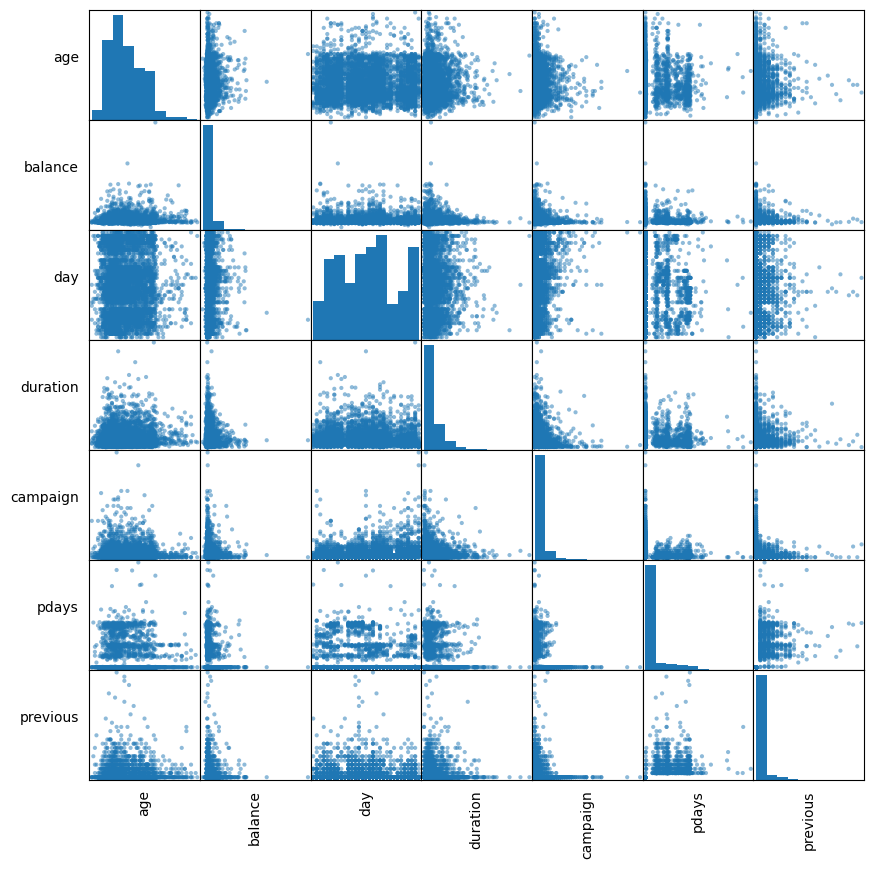

In [22]:
# Convert Pandas on Spark DataFrame to Spark DataFrame
numeric_data = psdf[numeric_features].to_pandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha(align="right")
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

There aren't any highly correlated variables, implying that we can keep them all for the model. However, day and month columns are not really useful, so will remove these two columns.

8. Use the `.drop()` method to remove the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes` method to verify that `sdf` now has the correct columns.

In [23]:
# [YOUR CODE HERE]
sdf = psdf.drop(labels=["day","month"], axis="columns")
sdf.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

## Part 3: Preparing Data for Training a Model

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. 
The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformation that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. 
The resulting output has the binary vectors appended to the end of each row. 
We use the StringIndexer again to encode our labels to label indices. 
Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [24]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# [YOUR CODE HERE] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple transformations and estimators together to specify our machine learning workflow. 
A Pipeline’s stages are specified as an ordered array.  
To run the pipeline on our Pandas on Spark DataFrame, we will convert it back to a Spark DataFrame using the **`to_spark()`** command

1. Fit a pipeline on df.

In [25]:
from pyspark.ml import Pipeline
sdf = sdf.to_spark()
pipeline = Pipeline(stages=stages)
# [YOUR CODE HERE]
pipelineModel = pipeline.fit(sdf)

/Users/noelnamai/miniconda3/envs/mle/lib/python3.8/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [26]:
# [YOUR CODE HERE]
transformed_df = pipelineModel.transform(df)
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vecto

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [27]:
# [YOUR CODE HERE]
selectedCols = ["label", "features"] + sdf.columns
sdf = transformed_df.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. Let's view the first five rows of the `sdf` DataFrame using the methods we learned in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [28]:
# [YOUR CODE HERE]
sdf.show(5)

pd.DataFrame(data=sdf.take(5), columns=sdf.columns)

22/11/28 21:42:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|label|            features|age|       job| marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| failure| no|
|  0.0|(30,[0,11,14,16,1...| 30|management| married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| unknown| no|
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|    747|     no

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure,no
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown,no
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,747,no,no,cellular,141,2,176,3,failure,no
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",40,management,married,tertiary,no,194,no,yes,cellular,189,2,-1,0,unknown,no
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38,management,divorced,unknown,no,0,yes,no,cellular,96,2,-1,0,unknown,no


5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [29]:
# [YOUR CODE HERE]
train, test = sdf.randomSplit([0.7, 0.3], seed=123)

6. What are the sizes of the training and test sets?

In [30]:
# [YOUR CODE HERE]
print(train.count())
print(test.count())

3213
1308


## Part 5: Logistic Regression Model

Optional:
- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a logistic regression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [31]:
from pyspark.ml.classification import LogisticRegression

# [YOUR CODE HERE]
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(train)

2. We can obtain the coefficients by using logistic regression model’s attributes. Look at the following plot of the beta coefficients.

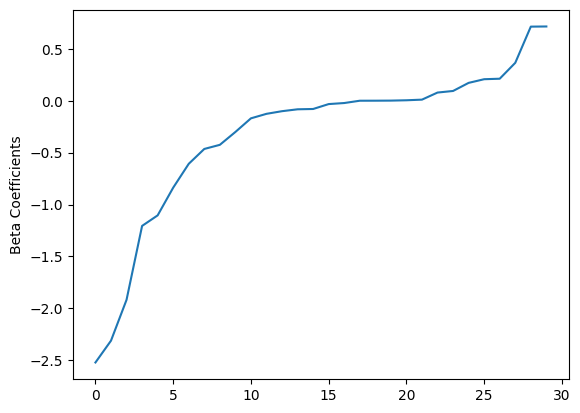

In [32]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [33]:
# [YOUR CODE HERE]
predictions = lrModel.transform(test)

4. View the first 10 rows of the `predictions` DataFrame.

In [34]:
# [YOUR CODE HERE]
predictions.show(10)

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|     11|    yes|  no|cellular|     104|       3|   -1|       0| unknown| no|[3.35235962630276...|[0.96618201990375...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 36|management|married|secondary|     no|    644|    yes|  no|cellular|      54|       2|   -1|       0| unknown| no|[3.47453504396489...|[0.96995446444975...|       0.0|
|  0.

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
# [YOUR CODE HERE]
evaluator.evaluate(predictions)

0.8668166663736981

## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [36]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select("age", "job", "label", "rawPrediction", "prediction", "probability").show(10)

22/11/28 21:42:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/28 21:42:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.26028842898918...|       0.0|[0.92557180355257...|
| 36|management|  0.0|[1.29217893522949...|       0.0|[0.92984806881880...|
| 48|management|  0.0|[0.61691207312694...|       0.0|[0.77448718836894...|
| 56|management|  0.0|[0.21396614174558...|       0.0|[0.60537980888389...|
| 58|management|  0.0|[1.26862735713734...|       0.0|[0.92671259503813...|
| 36|management|  0.0|[1.18305433376023...|       0.0|[0.91420614216102...|
| 34|management|  0.0|[1.10773244881183...|       0.0|[0.9016296931913

2. Perform cross-validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 4, 6])
    .addGrid(gbt.maxBins, [20, 60])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8820275741648937

### Algorithm Understanding.

    1. How does the Gradient-Boosted Tree algorithm work in classification?

    - Gradient Boosting is a technique of producing an additive predictive model by combining various weak predictors i.e. decision trees.
    - All the trees are conncted in series and each tree tries to minimise the error of the previous tree.
    - The weak learners are fit in such a way that each new learner fits into the residuals of the previous step so as the model improves. The final model aggregates the result of each step and produces a strong learner. 
    - A loss function is used to detect the residuals. Logarithmic loss (log loss) can be used for classification tasks.
    
    2. How does Gradient Boost differ from AdaBoost and Logistic Regression?

    - Adaboost used decision stumps (decision trees with only a single split) as weak learners and attaches more weight to difficult to classify instances and less weight to easy to classify instances.
    - Logistic regression is a classification algorithm that models the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome.
    - Gradient boosting algorithm uses the weighted average of individual outputs as the final outputs and uses gradient descent as a loss function to minimize loss and converge upon a final output value.

### Interview Readiness.

    1. What is a Delta Lake and how does it offer a solution to building reliable data pipelines?

    - Delta Lake is the optimized storage layer that provides the foundation for storing data and tables in the Databricks Lakehouse Platform. Delta Lake is the default storage format for all operations on Databricks. Unless otherwise specified, all tables on Databricks are Delta tables.
    - Delta Live Tables simplifies ETL workloads through optimized execution and automated infrastructure deployment and scaling.

    2. When working with Pandas, we use the class pandas.core.frame.DataFrame and when working with the pandas API in Spark, we use the class pyspark.pandas.frame.DataFrame, are these the same, explain why or why not?
    
    - pandas.core.frame.DataFrame is the primary pandas data structure which represents tabular data in two-dimensional and size-mutable data structure.
    - pyspark.sql.dataframe.DataFrame returns the current DataFrame as a Spark DataFrame.
    - pyspark.sql.dataframe.DataFrame has Spark related features which are missing in Pandas but Spark has them.

    3. What is a Machine Learning pipeline is and why it’s important?

    - A Machine Learning Pipeline is a means of automating the machine learning workflow by enabling data to be transformed and correlated into a model that can then be analyzed to achieve outputs thus makeing the process of inputting data into the machine learning model fully automated.
    - In a machine learning pipeline, each part of your workflow is abstracted into an independent service.
    - A machine learning pipeline architecture solves the problems that arise at scale:
    
    a) Volume: only call parts of the workflow when you need them, and cache or store results that you plan on reusing.
    b) Variety: when you expand your model portfolio, you can use pieces of the beginning stages of the workflow by simply pipelining them into the new models without replicating them.
    c) Versioning: when services are stored in a central location and pipelined together into various models, there is only one copy of each piece to update. All instances of that code will update when you update the original.
    
    4. What are the steps in a Machine Learning workflow?

    a) Gathering data.
    b) Data preprocessing.
    c) Model selection.
    d) Model training.
    e) Model testing.
    e) Model evaluation.
    f) Parameter tuning.
    g) Model deployment.
    h) Monitoring the predictions.

## Acknowledgements


This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)